Here we're going to clean up the permits dataset we got from San Jose, and check whether it's in line with the permits dataset we got from ABAG.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from housing_elements import san_jose_permits, utils, geocode_cache
from IPython.display import Markdown

## Load building permits data

In [50]:
from importlib import reload
reload(san_jose_permits)
reload(utils)

<module 'housing_elements.utils' from '/Users/sidharthkapur/personal-workspace/housing-elements/housing_elements/utils.py'>

In [51]:
%%time
abag_permits_df = utils.load_all_new_building_permits('San Jose')

/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


CPU times: user 13.4 s, sys: 398 ms, total: 13.8 s
Wall time: 15.8 s


In [53]:
%%time
permits_df = san_jose_permits.load_all_permits()

CPU times: user 13.1 s, sys: 1.55 s, total: 14.7 s
Wall time: 15.3 s


In [55]:
abag_permits_df.geometry.isnull().mean()

0.0

In [56]:
permits_df.geometry.isnull().mean()

0.0

Nice! The geocoder got all of them.

How much to buffer when matching points? Let's say that we're willing to tolerate 50 feet of distance (roughly the width of a standard suburban California lot) between points. That's about 15 meters.

I searched EPSG for "California", and [EPSG:3310](http://epsg.io/3310), the California Albers projection (meters), was the top result. Apparently this is the project that the state of California recommends. So I'll switch to this projection, then buffer 15 meters before joining.

In [60]:
abag_permits_meters_df = abag_permits_df.to_crs('EPSG:3310')
permits_meters_df = permits_df.to_crs('EPSG:3310')

abag_permits_buffered_df = abag_permits_meters_df.copy()
abag_permits_buffered_df.geometry = abag_permits_meters_df.geometry.buffer(15)

In [61]:
merged_df = gpd.sjoin(
    abag_permits_buffered_df,
    permits_meters_df,
    how='left',
    op='intersects',
)

In [64]:
merged_df_2 = gpd.sjoin(
    permits_meters_df,
    abag_permits_buffered_df,
    how='left',
    op='intersects',
)

In [79]:
merged_df_3 = abag_permits_df.merge(
    permits_df.dropna(subset=['apn']),
    how='left',
    on='apn'
)

In [81]:
merged_df_4 = permits_df.merge(
    abag_permits_df.dropna(subset=['apn']),
    how='left',
    on='apn'
)

In [62]:
merged_df['permyear_right'].notnull().mean()

0.3480392156862745

In [65]:
merged_df_2['permyear_right'].notnull().mean()

0.5587167070217918

In [82]:
merged_df_3['permyear_y'].notnull().mean()

0.8372429127292941

In [83]:
merged_df_4['permyear_y'].notnull().mean()

0.9096509240246407

Ughhh.... so the geocoding is actually worse somehow.

In [100]:
merged_df_3[
    merged_df_3['permyear_y'].isnull()
]

,objectid,joinid,permyear_x,county,jurisdictn,apn,address_x,zip,projname,hcategory,...,WORKDESC,SQUAREFOOT,PERMITAPPR,SUBDESC,ISSUEDATE,OBJECTID_y,ENTERPRISE,ISSUEDATEU,permyear_y,corrected
31,NaN,ae41b49a-7976-11e8-adc0-fa7ae01bbebc,2017,6085.0,San Jose,42108045,15110 SAMARITAN DR,NaN,NaN,SU,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
32,NaN,ae41b6de-7976-11e8-adc0-fa7ae01bbebc,2017,6085.0,San Jose,30723036,1338 FLORA AV,NaN,NaN,SU,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
33,NaN,ae41b922-7976-11e8-adc0-fa7ae01bbebc,2017,6085.0,San Jose,25451038,1919 FARRAGUT WY,NaN,NaN,SU,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
35,NaN,ae41bdb4-7976-11e8-adc0-fa7ae01bbebc,2017,6085.0,San Jose,48443085,80 SIERRA VISTA PL,NaN,NaN,SU,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
36,NaN,ae41c200-7976-11e8-adc0-fa7ae01bbebc,2017,6085.0,San Jose,46239027,349 GRANDPARK CL,NaN,NaN,SU,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8990,NaN,NaN,2019,NaN,NaN,40338003,5272 YORKTON WAY,NaN,NaN,ADU,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
8991,NaN,NaN,2019,NaN,NaN,40330056,12730 LANTANA AVENUE,NaN,NaN,ADU,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
8992,NaN,NaN,2019,NaN,NaN,29921010,1015 PHELPS AVENUE,NaN,NaN,ADU,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
8993,NaN,NaN,2019,NaN,NaN,67318042,3210 PUMPHERSTON WAY,NaN,NaN,ADU,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN


In [104]:
missing_df = gpd.GeoDataFrame(
    merged_df_3[
        merged_df_3['permyear_y'].isnull()
    ].rename(columns={'geometry_x': 'geometry'})
).to_crs('EPSG:3310')

missing_df.geometry = missing_df.geometry.buffer(15)

In [105]:
merged_missing_df = gpd.sjoin(
    missing_df,
    permits_meters_df,
    op='intersects',
    how='left',
)

In [109]:
merged_missing_df['apn_right'].isnull().mean()

0.6552315608919382

In [66]:
merged_df[['address_left', 'address_right']]

,address_left,address_right
0,5062 EDENVALE AV,NaN
1,5058 EDENVALE AV,NaN
2,5052 EDENVALE AV,NaN
3,1902 NEVETS LN,NaN
4,1942 GALILEO LN,NaN
...,...,...
2346,5272 YORKTON WAY,NaN
2347,12730 LANTANA AVENUE,NaN
2348,1015 PHELPS AVENUE,NaN
2349,3210 PUMPHERSTON WAY,NaN


<AxesSubplot:>

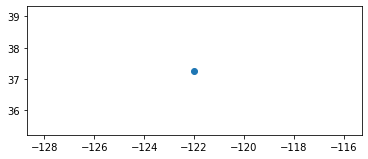

In [71]:
abag_permits_df[
    abag_permits_df['address'].str.lower().str.contains('yorkton')
].plot()

In [70]:
permits_df[
    permits_df['address'].str.lower().str.contains('edenvale')
]

,apn,address,totalunit,state,APPLICANT,FOLDERNUM,geometry,INTID,CONTRACTOR,FINALDATEU,...,WORKDESC,SQUAREFOOT,PERMITAPPR,SUBDESC,ISSUEDATE,OBJECTID,ENTERPRISE,ISSUEDATEU,permyear,corrected


In [218]:
address_results = geocode_cache.lookup(addresses)

Let's check that the dupes we allowed are actually not dupes:

In [7]:
for (apn, address), group in permits_df.groupby(['apn', 'address']):
    if len(group) > 1:
        display(Markdown(f'# {apn}: {address.title()}'))
        display(
            group.sort_values(['apn', 'ISSUEDATE'])[[
                'apn', 'address', 'totalunit', 'WORKDESC', 'ISSUEDATE', 'SUBDESC', 'CONTRACTOR', 'ENTERPRISE', 'SQUAREFOOT', 'APPLICANT', 'state'
            ]]
        )

# 24911077: 734 N 12Th St  , San Jose Ca 95112

,apn,address,totalunit,WORKDESC,ISSUEDATE,SUBDESC,CONTRACTOR,ENTERPRISE,SQUAREFOOT,APPLICANT,state
46,24911077,"734 N 12TH ST , SAN JOSE CA 95112",1.0,New Construction,2019-10-06 17:00:00,2nd Unit Added,None,PLN-PBAC-0000020432,404.0,TFR MANAGEMENT GROUP INC CHRISTOPHER WENCEL,active
47,24911077,"734 N 12TH ST , SAN JOSE CA 95112",1.0,New Construction,2019-10-06 17:00:00,Single-Family,None,PLN-PBAC-0000020433,2934.0,TFR MANAGEMENT GROUP INC CHRISTOPHER WENCEL,active


# 25905079: 10152  Cherry Canyon Rd  , San Jose Ca 95120-0000

,apn,address,totalunit,WORKDESC,ISSUEDATE,SUBDESC,CONTRACTOR,ENTERPRISE,SQUAREFOOT,APPLICANT,state
92,25905079,"10152 CHERRY CANYON RD , SAN JOSE CA 95120-0000",1.0,New Construction,2019-10-10 17:00:00,2nd Unit Added,JON ANDERSON BUILDS JON ANDERSON,PLN-PBAC-0000015914,640.0,JON ANDERSON BUILDS JON ANDERSON,active
93,25905079,"10152 CHERRY CANYON RD , SAN JOSE CA 95120-0000",1.0,New Construction,2019-10-10 17:00:00,Single-Family,None,PLN-PBAC-0000015915,7242.0,JON ANDERSON BUILDS JON ANDERSON,active


# 25932045: 171 W Julian St  , San Jose Ca 95110-2407

,apn,address,totalunit,WORKDESC,ISSUEDATE,SUBDESC,CONTRACTOR,ENTERPRISE,SQUAREFOOT,APPLICANT,state
98,25932045,"171 W JULIAN ST , SAN JOSE CA 95110-2407",24.0,New Construction,2018-07-31 17:00:00,Apartment,None,PLN-PBAC-0000020505,31701.0,171 W JULIAN ST. APARTMENTS INVESTORS LL DANA...,active
97,25932045,"171 W JULIAN ST , SAN JOSE CA 95110-2407",357.0,New Construction,2018-08-26 17:00:00,Apartment,None,PLN-PBAC-0000020504,473336.0,171 W JULIAN ST. APARTMENTS INVESTORS LL DANA...,active


# 25935042: 28 N Almaden Av  , San Jose Ca 95113

,apn,address,totalunit,WORKDESC,ISSUEDATE,SUBDESC,CONTRACTOR,ENTERPRISE,SQUAREFOOT,APPLICANT,state
107,25935042,"28 N ALMADEN AV , SAN JOSE CA 95113",25.0,New Construction,2017-08-07 17:00:00,Apt/Condo/Townhouse,None,PLN-PBAC-0000019955,120000.0,MCREF SAN PEDRO SQUARE LLC,active
108,25935042,"28 N ALMADEN AV , SAN JOSE CA 95113",176.0,New Construction,2018-05-02 17:00:00,Apt/Condo/Townhouse,None,PLN-PBAC-0000019956,136500.0,MCREF SAN PEDRO SQUARE LLC,active


# 26437060: 975 S 1St St  , San Jose Ca 95110-3128

,apn,address,totalunit,WORKDESC,ISSUEDATE,SUBDESC,CONTRACTOR,ENTERPRISE,SQUAREFOOT,APPLICANT,state
111,26437060,"975 S 1ST ST , SAN JOSE CA 95110-3128",48.0,New Construction,2016-06-30 17:00:00,Apt/Condo/Townhouse,THE PACIFIC COMPANIES,PLN-PBAC-0000020113,80395.0,THE PACIFIC COMPANIES,active
112,26437060,"975 S 1ST ST , SAN JOSE CA 95110-3128",2.0,New Construction,2016-06-30 17:00:00,Duplex,THE PACIFIC COMPANIES,PLN-PBAC-0000020114,3454.0,THE PACIFIC COMPANIES,active


# 65445032: 3289  Ingersoll Dr  , San Jose Ca 95148-3136

,apn,address,totalunit,WORKDESC,ISSUEDATE,SUBDESC,CONTRACTOR,ENTERPRISE,SQUAREFOOT,APPLICANT,state
330,65445032,"3289 INGERSOLL DR , SAN JOSE CA 95148-3136",1.0,New Construction,2021-02-25 16:00:00,2nd Unit Added,None,PLN-PBAC-0000012555,427.0,SUMMER CONST CONSULTING LLC JING SHEN,active
331,65445032,"3289 INGERSOLL DR , SAN JOSE CA 95148-3136",1.0,New Construction,2021-02-25 16:00:00,2nd Unit Added,None,PLN-PBAC-0000012554,749.0,SUMMER CONST CONSULTING LLC JING SHEN,active


# 67610035: 1918  Threadneedle Wy  , San Jose Ca 95121-1547

,apn,address,totalunit,WORKDESC,ISSUEDATE,SUBDESC,CONTRACTOR,ENTERPRISE,SQUAREFOOT,APPLICANT,state
521,67610035,"1918 THREADNEEDLE WY , SAN JOSE CA 95121-1547",1.0,New Construction,2020-10-05 17:00:00,2nd Unit Added,None,PLN-PBAC-0000019462,480.0,TON-THAT HUNG-BINH ET AL,active
522,67610035,"1918 THREADNEEDLE WY , SAN JOSE CA 95121-1547",1.0,New Construction,2020-10-05 17:00:00,2nd Unit Added,None,PLN-PBAC-0000019463,451.0,TON-THAT HUNG-BINH ET AL,active


Yes, these are all okay.

- The last two are triplexes enabled by the 2019 state ADU legislation ❤️.
- The first two are new single-family homes built with ADUs (you also love to see this!).
- The three in the middle are larger projects that for whatever reason, got separate building permits for different parts of the projects. If you Google these projects, you'll find that the sum of the unit counts here is the actual number of units in the completed project: [The Julian](https://intracorphomes.com/communities/171-w-julian-apartments/) (171 W Julian St) has 381 units, [Modera San Pedro Square](https://millcreekplaces.com/community/modera-san-pedro-square/) (28 N Almaden Ave) has 201 units, and [The NEO on First](https://www.compass-cre.com/listings?propertyId=SouthFirstRetail) (975 S 1st St) has 50 units.

Now, let's look at the other dupes: where the same APN has multiple addresses.

In [8]:
dupe_apns_different_addresses = permits_df.groupby('apn').apply(lambda g: True if g['address'].nunique() > 1 else False).loc[lambda x: x].index

In [9]:
dupe_apns_different_addresses

Index(['23702064', '23703080', '24102042', '24103020, 24104006,', '24104011',
       '24123053', '24434016', '24913048', '24963032', '25404079', '25404080',
       '25406042', '25455006', '25932042', '25932079', '25933011', '26414024',
       '27719012', '27903020', '29926059', '37222042', '41221046, 41221047',
       '41406014', '41406035', '43403093', '43411008', '45509063', '45528011',
       '45930079', '46414017', '46701008', '46705007', '46720008', '46731016',
       '47766004', '57501002', '58308028', '58311073', '60120034', '65925001',
       '67029022', '67910006', '68002010', '68007008', '68456028', '68503002',
       '69601002', '69601020', '70101006', '70117070', '70162007', '70607020',
       '70608008', '70608008, 70608022,', '70608011', '70608015', '70609050'],
      dtype='object', name='apn')

I'll just print all of them here. I briefly looked through them, they seem legit. (Mostly large single-family subdivisions, with all their permits issued at the same time.) Just leaving this for reference, in case anyone wants to take another look and check if there are any dupes here.

In [35]:
for apn in dupe_apns_different_addresses:
    group = permits_df[permits_df['apn'] == apn]
    display(Markdown(f'# {apn}\n Total units: {group["totalunit"].astype(int).sum()}'))
    display(group[['address', 'SUBDESC', 'totalunit', 'ISSUEDATE']].sort_values('ISSUEDATE'))

# 23702064
 Total units: 2

,address,SUBDESC,totalunit,ISSUEDATE
0,"724 HARRISON ST 2 , SAN JOSE CA 95125",2nd Unit Added,1.0,2021-01-25 16:00:00
1,"726 HARRISON ST 2 , SAN JOSE CA 95125",2nd Unit Added,1.0,2021-01-25 16:00:00


# 23703080
 Total units: 29

,address,SUBDESC,totalunit,ISSUEDATE
3,"1036 FOXGLOVE PL , SAN JOSE CA 95131-2431",Apt/Condo/Townhouse,7.0,2015-02-26 16:00:00
2,"1061 HAREBELL PL , SAN JOSE CA 95131-2431",Apt/Condo/Townhouse,7.0,2015-05-05 17:00:00
5,"966 ARROWLEAF PL , SAN JOSE CA 95131-2431",Apt/Condo/Townhouse,7.0,2015-09-22 17:00:00
4,"951 ARROWLEAF PL , SAN JOSE CA 95131-2431",Apt/Condo/Townhouse,8.0,2015-10-07 17:00:00


# 24102042
 Total units: 9

,address,SUBDESC,totalunit,ISSUEDATE
6,"1331 ARAUJO ST , SAN JOSE CA 95131",Single-Family,1.0,2018-04-29 17:00:00
7,"1325 ARAUJO ST , SAN JOSE CA 95131",Single-Family,1.0,2018-04-29 17:00:00
8,"1787 CLOVE CT , SAN JOSE CA 95131",Single-Family,1.0,2018-04-29 17:00:00
9,"1779 CLOVE CT , SAN JOSE CA 95131",Single-Family,1.0,2018-04-29 17:00:00
10,"1773 CLOVE CT , SAN JOSE CA 95131",Single-Family,1.0,2018-04-29 17:00:00
11,"1767 CLOVE CT , SAN JOSE CA 95131",Single-Family,1.0,2018-04-29 17:00:00
12,"1349 ARAUJO ST , SAN JOSE CA 95131",Single-Family,1.0,2018-04-29 17:00:00
13,"1343 ARAUJO ST , SAN JOSE CA 95131",Single-Family,1.0,2018-04-29 17:00:00
14,"1337 ARAUJO ST , SAN JOSE CA 95131",Single-Family,1.0,2018-04-29 17:00:00


# 24103020, 24104006,
 Total units: 2

,address,SUBDESC,totalunit,ISSUEDATE
15,"1655 MERCADO WY , SAN JOSE CA 95131",Single-Family,1.0,2016-05-01 17:00:00
16,"1648 SHORE DR , SAN JOSE CA 95133-0000",Single-Family,1.0,2021-01-14 16:00:00


# 24104011
 Total units: 432

,address,SUBDESC,totalunit,ISSUEDATE
17,"1022 GIACOMO LN , SAN JOSE CA 95133-1059",Apt/Condo/Townhouse,7.0,2015-12-15 16:00:00
19,"1028 GIACOMO LN , SAN JOSE CA 95133-1059",Apt/Condo/Townhouse,8.0,2015-12-15 16:00:00
20,"1033 BELLANTE LN 1 , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,7.0,2017-02-13 16:00:00
21,"1032 ABRUZZO LN 1 , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,7.0,2017-03-01 16:00:00
34,"1035 GIACOMO LN 1 , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,7.0,2017-03-01 16:00:00
18,"1027 GIACOMO LN 1 , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,7.0,2017-07-25 17:00:00
35,"1026 ABRUZZO LN 1 , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,7.0,2017-09-26 17:00:00
36,"1020 BELLANTE LN 1 , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,7.0,2017-10-05 17:00:00
27,"1008 ABRUZZO LN 1 , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,3.0,2017-12-10 16:00:00
28,"1017 GABBIANO LN 1 , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,3.0,2017-12-10 16:00:00


# 24123053
 Total units: 5

,address,SUBDESC,totalunit,ISSUEDATE
37,"1596 RINGWOOD AV , SAN JOSE CA 95131",Single-Family,1.0,2020-12-17 16:00:00
38,"1598 RINGWOOD AV , SAN JOSE CA 95131",Single-Family,1.0,2020-12-17 16:00:00
39,"1566 MURPHY AV , SAN JOSE CA 95131",Single-Family,1.0,2020-12-17 16:00:00
40,"1592 RINGWOOD AV , SAN JOSE CA 95131",Single-Family,1.0,2020-12-17 16:00:00
41,"1588 RINGWOOD AV , SAN JOSE CA 95131",Single-Family,1.0,2020-12-17 16:00:00


# 24434016
 Total units: 4

,address,SUBDESC,totalunit,ISSUEDATE
42,"1705 RINGWOOD AV , SAN JOSE CA 95131",Single-Family,1.0,2020-02-09 16:00:00
43,"1701 RINGWOOD AV , SAN JOSE CA 95131",Single-Family,1.0,2020-02-09 16:00:00
44,"1709 RINGWOOD AV , SAN JOSE CA 95131",Single-Family,1.0,2020-02-09 16:00:00
45,"1713 RINGWOOD AV , SAN JOSE CA 95131",Single-Family,1.0,2020-02-09 16:00:00


# 24913048
 Total units: 2

,address,SUBDESC,totalunit,ISSUEDATE
48,"314 N 20TH ST 2 , SAN JOSE CA 95112",2nd Unit Added,1.0,2020-11-08 16:00:00
49,"316 N 20TH ST 2 , SAN JOSE CA 95112",2nd Unit Added,1.0,2020-11-08 16:00:00


# 24963032
 Total units: 2

,address,SUBDESC,totalunit,ISSUEDATE
50,"450 N 21ST ST , SAN JOSE CA 95112-1747",Single-Family,1.0,2020-07-07 17:00:00
51,"450 N 21ST ST 2 , SAN JOSE CA 95112",2nd Unit Added,1.0,2020-12-22 16:00:00


# 25404079
 Total units: 44

,address,SUBDESC,totalunit,ISSUEDATE
56,"651 BLACKBURY LN A , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,12.0,2017-08-17 17:00:00
52,"1805 SABLE PL E , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,7.0,2017-09-26 17:00:00
53,"1807 DOBBIN DR F , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,7.0,2017-09-26 17:00:00
54,"1804 SLATE PL D , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,7.0,2017-09-26 17:00:00
55,"601 BLACKBURY LN B , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,11.0,2017-10-23 17:00:00


# 25404080
 Total units: 44

,address,SUBDESC,totalunit,ISSUEDATE
57,"1859 MIDNIGHT CL , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,10.0,2015-09-28 17:00:00
58,"1850 NEWBURY PARK DR , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,14.0,2015-09-28 17:00:00
59,"1863 NEWBURY PARK DR , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,7.0,2016-02-11 16:00:00
60,"2002 MAHURON CL , SAN JOSE CA 95133-1702",Apt/Condo/Townhouse,13.0,2017-01-25 16:00:00


# 25406042
 Total units: 178

,address,SUBDESC,totalunit,ISSUEDATE
74,"2695 BEECHNUT DR 19 , SAN JOSE CA 95133",Apt/Condo/Townhouse,7.0,2018-08-26 17:00:00
82,"662 TOBY CT 17 , SAN JOSE CA 95133",Apt/Condo/Townhouse,5.0,2018-08-27 17:00:00
68,"2722 GIMELLI WY 29 , SAN JOSE CA 95133",Apt/Condo/Townhouse,5.0,2018-09-09 17:00:00
81,"629 TOBY CT 16 , SAN JOSE CA 95133",Apt/Condo/Townhouse,5.0,2018-09-09 17:00:00
80,"612 COCO CT 15 , SAN JOSE CA 95133",Apt/Condo/Townhouse,5.0,2018-09-09 17:00:00
83,"2572 GIMELLI WY 27 , SAN JOSE CA 95133",Apt/Condo/Townhouse,12.0,2018-10-28 17:00:00
79,"595 COCO CT 14 , SAN JOSE CA 95133",Apt/Condo/Townhouse,5.0,2018-11-12 16:00:00
73,"702 FRUIT RANCH LP 28 , SAN JOSE CA 95133",Apt/Condo/Townhouse,13.0,2018-11-12 16:00:00
77,"561 JAYNE CT 12 , SAN JOSE CA 95133",Apt/Condo/Townhouse,5.0,2018-11-12 16:00:00
78,"578 JAYNE CT 13 , SAN JOSE CA 95133",Apt/Condo/Townhouse,5.0,2018-11-12 16:00:00


# 25455006
 Total units: 38

,address,SUBDESC,totalunit,ISSUEDATE
89,"1968 NEVETS LN , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,8.0,2017-05-17 17:00:00
91,"1901 NEVETS LN , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,10.0,2017-10-23 17:00:00
88,"1927 NEVETS LN , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,10.0,2017-12-06 16:00:00
90,"1963 NEVETS LN , SAN JOSE CA 95133-0000",Apt/Condo/Townhouse,10.0,2017-12-06 16:00:00


# 25932042
 Total units: 21

,address,SUBDESC,totalunit,ISSUEDATE
95,"240 TERRAINE ST , SAN JOSE CA 95125",Apt/Condo/Townhouse,7.0,2018-05-21 17:00:00
96,"238 ELEMENT RD 3 , SAN JOSE CA 95110",Apt/Condo/Townhouse,7.0,2018-05-21 17:00:00
94,"199 DEVINE ST 2 , SAN JOSE CA 95110",Apt/Condo/Townhouse,7.0,2019-09-29 17:00:00


# 25932079
 Total units: 14

,address,SUBDESC,totalunit,ISSUEDATE
100,"178 VELOCITY WY , SAN JOSE CA 95110",Apt/Condo/Townhouse,7.0,2019-09-29 17:00:00
99,"180 TERRAINE ST , SAN JOSE CA 95110",Apt/Condo/Townhouse,7.0,2019-10-10 17:00:00


# 25933011
 Total units: 43

,address,SUBDESC,totalunit,ISSUEDATE
104,"103 W JULIAN ST 1 , SAN JOSE CA 95110-0024",Apt/Condo/Townhouse,7.0,2018-02-22 16:00:00
105,"131 NEXUS LP 2 , SAN JOSE CA 95110-0024",Apt/Condo/Townhouse,8.0,2018-04-16 17:00:00
101,"163 NEXUS LP 4 , SAN JOSE CA 95110-0024",Apt/Condo/Townhouse,8.0,2018-09-10 17:00:00
106,"162 NEXUS LP 3 , SAN JOSE CA 95110-0024",Apt/Condo/Townhouse,8.0,2018-09-10 17:00:00
102,"202 PROXIMITY WY 5 , SAN JOSE CA 95110-0024",Apt/Condo/Townhouse,7.0,2019-04-15 17:00:00
103,"203 PROXIMITY WY 6 , SAN JOSE CA 95110-0024",Apt/Condo/Townhouse,5.0,2019-04-15 17:00:00


# 26414024
 Total units: 537

,address,SUBDESC,totalunit,ISSUEDATE
110,"333 SUNOL ST , SAN JOSE CA 95126-3406",Apt/Condo/Townhouse,268.0,2017-03-07 16:00:00
109,"355 SUNOL ST , SAN JOSE CA 95126-3406",Apt/Condo/Townhouse,269.0,2018-01-31 16:00:00


# 27719012
 Total units: 6

,address,SUBDESC,totalunit,ISSUEDATE
113,"401 DOUGLAS PL , SAN JOSE CA 95126-3221",Single-Family,1.0,2018-05-06 17:00:00
114,"407 DOUGLAS PL , SAN JOSE CA 95126-3221",Single-Family,1.0,2018-05-06 17:00:00
115,"413 DOUGLAS PL , SAN JOSE CA 95126-3221",Single-Family,1.0,2018-05-06 17:00:00
116,"419 DOUGLAS PL , SAN JOSE CA 95126-3221",Single-Family,1.0,2018-05-06 17:00:00
117,"430 DOUGLAS PL , SAN JOSE CA 95126-3221",Single-Family,1.0,2018-05-06 17:00:00
118,"423 DOUGLAS PL , SAN JOSE CA 95126-3221",Single-Family,1.0,2018-05-06 17:00:00


# 27903020
 Total units: 2

,address,SUBDESC,totalunit,ISSUEDATE
119,"2822 MOORPARK AV , SAN JOSE CA 95128-3156",Single-Family,1.0,2018-08-19 17:00:00
120,"2842 MOORPARK AV , SAN JOSE CA 95128-3156",Single-Family,1.0,2018-08-19 17:00:00


# 29926059
 Total units: 636

,address,SUBDESC,totalunit,ISSUEDATE
121,"877 S WINCHESTER BL 2 , SAN JOSE CA 95128-2910",Apt/Condo/Townhouse,267.0,2017-10-18 17:00:00
122,"919 S WINCHESTER BL 1 , SAN JOSE CA 95128-2910",Apt/Condo/Townhouse,369.0,2017-10-18 17:00:00


# 37222042
 Total units: 6

,address,SUBDESC,totalunit,ISSUEDATE
123,"7157 SHARON PL , SAN JOSE CA 95129",Single-Family,1.0,2018-07-24 17:00:00
124,"7151 SHARON PL , SAN JOSE CA 95129",Single-Family,1.0,2018-07-24 17:00:00
125,"7163 SHARON PL , SAN JOSE CA 95129",Single-Family,1.0,2018-07-24 17:00:00
126,"7171 SHARON PL , SAN JOSE CA 95129",Single-Family,1.0,2018-07-24 17:00:00
127,"7152 SHARON PL , SAN JOSE CA 95129",Single-Family,1.0,2018-07-24 17:00:00
128,"7160 SHARON PL , SAN JOSE CA 95129",Single-Family,1.0,2018-07-24 17:00:00


# 41221046, 41221047
 Total units: 2

,address,SUBDESC,totalunit,ISSUEDATE
129,"2554 ELDEN GLEN , SAN JOSE CA 95008",Single-Family,1.0,2018-11-07 16:00:00
130,"2546 ELDEN GLEN , SAN JOSE CA 95008",Single-Family,1.0,2018-11-07 16:00:00


# 41406014
 Total units: 5

,address,SUBDESC,totalunit,ISSUEDATE
131,"2222 IDA DR , SAN JOSE CA 95124-0000",Duplex,2.0,2017-05-17 17:00:00
132,"2204 IDA DR , SAN JOSE CA 95124-0000",Apt/Condo/Townhouse,3.0,2017-05-17 17:00:00


# 41406035
 Total units: 4

,address,SUBDESC,totalunit,ISSUEDATE
133,"2233 IDA DR , SAN JOSE CA 95124-0000",Single-Family,1.0,2018-08-23 17:00:00
134,"2239 IDA DR , SAN JOSE CA 95124-0000",Single-Family,1.0,2018-08-23 17:00:00
135,"2245 IDA DR , SAN JOSE CA 95124-0000",Single-Family,1.0,2018-08-23 17:00:00
136,"2251 IDA DR , SAN JOSE CA 95124-0000",Single-Family,1.0,2018-08-23 17:00:00


# 43403093
 Total units: 3

,address,SUBDESC,totalunit,ISSUEDATE
137,"652 WILLOW ST , SAN JOSE CA 95125-5714",Manufactured Home,1.0,2015-04-27 17:00:00
138,"648 WILLOW ST , SAN JOSE CA 95125-5714",Manufactured Home,1.0,2015-04-27 17:00:00
139,"646 WILLOW ST , SAN JOSE CA 95125-5714",Manufactured Home,1.0,2015-04-27 17:00:00


# 43411008
 Total units: 3

,address,SUBDESC,totalunit,ISSUEDATE
140,"236 FLOYD ST , SAN JOSE CA 95110-3344",Single-Family,1.0,2016-09-06 17:00:00
141,"228 FLOYD ST , SAN JOSE CA 95110-3344",Single-Family,1.0,2016-09-21 17:00:00
142,"222 FLOYD ST , SAN JOSE CA 95110-3344",Single-Family,1.0,2016-09-21 17:00:00


# 45509063
 Total units: 158

,address,SUBDESC,totalunit,ISSUEDATE
143,"260 MONTALCINO CL , SAN JOSE CA 95111-3104",Apt/Condo/Townhouse,5.0,2015-04-02 17:00:00
144,"255 MONTALCINO CL , SAN JOSE CA 95111-3104",Apt/Condo/Townhouse,7.0,2015-06-14 17:00:00
146,"203 SIDERNO CT , SAN JOSE CA 95111-3104",Apt/Condo/Townhouse,6.0,2015-06-14 17:00:00
147,"210 SIDERNO CT , SAN JOSE CA 95111-3104",Apt/Condo/Townhouse,6.0,2015-08-25 17:00:00
148,"201 ROSARNO CT , SAN JOSE CA 95111-3104",Apt/Condo/Townhouse,6.0,2015-08-25 17:00:00
145,"288 ESFAHAN CT , SAN JOSE CA 95111-3104",Apt/Condo/Townhouse,7.0,2015-09-27 17:00:00
153,"3 ESFAHAN DR 1 , SAN JOSE CA 95111-3104",Apt/Condo/Townhouse,4.0,2016-02-07 16:00:00
162,"61 MONTECITO VISTA DR 1 , SAN JOSE CA 95111-3104",Apt/Condo/Townhouse,8.0,2016-06-19 17:00:00
161,"2722 FORINO LN 1 , SAN JOSE CA 95111-3104",Apt/Condo/Townhouse,7.0,2016-06-19 17:00:00
160,"2726 TERNI CT 1 , SAN JOSE CA 95111-3104",Apt/Condo/Townhouse,7.0,2016-06-19 17:00:00


# 45528011
 Total units: 467

,address,SUBDESC,totalunit,ISSUEDATE
167,"2986 VALLEY OF HEARTS DELIGHT PL , SAN JOSE ...",Single-Family,1.0,2018-09-13 17:00:00
185,"2951 VALLEY OF HEARTS DELIGHT PL , SAN JOSE ...",Single-Family,1.0,2018-09-13 17:00:00
177,"111 LLANO DE LOS ROBLES AV 1 , SAN JOSE CA 95136",Apt/Condo/Townhouse,7.0,2018-09-13 17:00:00
186,"2957 VALLEY OF HEARTS DELIGHT PL , SAN JOSE ...",Single-Family,1.0,2018-09-13 17:00:00
183,"2973 VALLEY OF HEARTS DELIGHT PL 8 , SAN JOSE...",Apt/Condo/Townhouse,6.0,2018-09-23 17:00:00
...,...,...,...,...
281,"3048 LINA ST , SAN JOSE CA 95136",Single-Family,1.0,2020-11-05 16:00:00
290,"350 LLANO DE LOS ROBLES 1 , SAN JOSE CA 95136",Apt/Condo/Townhouse,10.0,2020-12-16 16:00:00
288,"3031 LINA 1 , SAN JOSE CA 95136",Apt/Condo/Townhouse,10.0,2020-12-16 16:00:00
289,"382 LLANO DE LOS ROBLES AV 1 , SAN JOSE CA 95136",Apt/Condo/Townhouse,10.0,2020-12-16 16:00:00


# 45930079
 Total units: 5

,address,SUBDESC,totalunit,ISSUEDATE
292,"3597 REINOSO CT , SAN JOSE CA 95136-1402",Single-Family,1.0,2017-12-04 16:00:00
293,"3591 REINOSO CT , SAN JOSE CA 95136-1402",Single-Family,1.0,2017-12-04 16:00:00
294,"3585 REINOSO CT , SAN JOSE CA 95136-1402",Single-Family,1.0,2017-12-04 16:00:00
295,"3582 REINOSO CT , SAN JOSE CA 95136-1402",Single-Family,1.0,2017-12-04 16:00:00
296,"3578 REINOSO CT , SAN JOSE CA 95136-1402",Single-Family,1.0,2017-12-04 16:00:00


# 46414017
 Total units: 8

,address,SUBDESC,totalunit,ISSUEDATE
297,"488 AGORA CT , SAN JOSE CA 95123-3142",Single-Family,1.0,2016-03-31 17:00:00
298,"482 AGORA CT , SAN JOSE CA 95123-3142",Single-Family,1.0,2016-03-31 17:00:00
299,"491 AGORA CT , SAN JOSE CA 95123-3142",Single-Family,1.0,2016-03-31 17:00:00
300,"485 AGORA CT , SAN JOSE CA 95123-3142",Single-Family,1.0,2016-03-31 17:00:00
301,"473 AGORA CT , SAN JOSE CA 95123-3142",Single-Family,1.0,2016-03-31 17:00:00
302,"470 AGORA CT , SAN JOSE CA 95123-3142",Single-Family,1.0,2016-03-31 17:00:00
303,"479 AGORA CT , SAN JOSE CA 95123-3142",Single-Family,1.0,2016-03-31 17:00:00
304,"476 AGORA CT , SAN JOSE CA 95123-3142",Single-Family,1.0,2016-03-31 17:00:00


# 46701008
 Total units: 11

,address,SUBDESC,totalunit,ISSUEDATE
305,"3099 LINA LN 1 , SAN JOSE CA 95125-0000",Apt/Condo/Townhouse,6.0,2016-01-26 16:00:00
306,"3086 MANUEL ST 1 , SAN JOSE CA 95125-0000",Apt/Condo/Townhouse,5.0,2016-08-22 17:00:00


# 46705007
 Total units: 3

,address,SUBDESC,totalunit,ISSUEDATE
307,"267 N 19TH ST , SAN JOSE CA 95116-2259",Single-Family,1.0,2018-05-02 17:00:00
308,"259 N 19TH ST , SAN JOSE CA 95112-1857",Single-Family,1.0,2018-05-02 17:00:00
309,"255 N 19TH ST , SAN JOSE CA 95112-1857",Single-Family,1.0,2018-05-02 17:00:00


# 46720008
 Total units: 630

,address,SUBDESC,totalunit,ISSUEDATE
311,"28 N 4TH ST 2 , SAN JOSE CA 95112",Apt/Condo/Townhouse,304.0,2017-08-15 17:00:00
310,"181 E SANTA CLARA ST 1 , SAN JOSE CA 95112",Apt/Condo/Townhouse,326.0,2018-12-02 16:00:00


# 46731016
 Total units: 2

,address,SUBDESC,totalunit,ISSUEDATE
312,"19 S 21ST ST 2 , SAN JOSE CA 95116",2nd Unit Added,1.0,2020-11-19 16:00:00
313,"25 S 21ST ST 2 , SAN JOSE CA 95116",2nd Unit Added,1.0,2020-12-02 16:00:00


# 47766004
 Total units: 2

,address,SUBDESC,totalunit,ISSUEDATE
315,"1771 LUCRETIA AV , SAN JOSE CA 95122-3814",Single-Family,1.0,2015-02-08 16:00:00
316,"1787 LUCRETIA AV , SAN JOSE CA 95122-3814",Single-Family,1.0,2015-02-08 16:00:00


# 57501002
 Total units: 5

,address,SUBDESC,totalunit,ISSUEDATE
317,"6039 GUADALUPE MINES RD , SAN JOSE CA 95120-...",Single-Family,1.0,2016-01-28 16:00:00
318,"6033 GUADALUPE MINES RD , SAN JOSE CA 95120-...",Single-Family,1.0,2016-01-28 16:00:00
319,"6027 GUADALUPE MINES RD , SAN JOSE CA 95120-...",Single-Family,1.0,2016-01-28 16:00:00
320,"6021 GUADALUPE MINES RD , SAN JOSE CA 95120-...",Single-Family,1.0,2016-01-28 16:00:00
321,"6015 GUADALUPE MINES RD , SAN JOSE CA 95120-...",Single-Family,1.0,2016-01-28 16:00:00


# 58308028
 Total units: 2

,address,SUBDESC,totalunit,ISSUEDATE
322,"7209 GLENVIEW DR , SAN JOSE CA 95120-0000",Single-Family,1.0,2019-09-26 17:00:00
323,"6997 HOLLOW LAKE WY , SAN JOSE CA 95120-0000",Single-Family,1.0,2020-09-30 17:00:00


# 58311073
 Total units: 2

,address,SUBDESC,totalunit,ISSUEDATE
324,"7253 GOLD CREEK WY , SAN JOSE CA 95120-4230",Single-Family,1.0,2019-08-25 17:00:00
325,"7253 GOLD CREEK WY 2 , SAN JOSE CA 95120",2nd Unit Added,1.0,2019-08-25 17:00:00


# 60120034
 Total units: 3

,address,SUBDESC,totalunit,ISSUEDATE
327,"3405 EAST HILLS DR , SAN JOSE CA 95127-2922",Single-Family,1.0,2017-11-21 16:00:00
328,"3399 EAST HILLS DR , SAN JOSE CA 95127-2922",Single-Family,1.0,2017-11-21 16:00:00
329,"3391 EAST HILLS DR , SAN JOSE CA 95127-2922",Single-Family,1.0,2017-11-21 16:00:00


# 65925001
 Total units: 7

,address,SUBDESC,totalunit,ISSUEDATE
332,"3721 DARSHAN CT , SAN JOSE CA 95148-3201",Single-Family,1.0,2018-07-31 17:00:00
333,"3727 DARSHAN CT , SAN JOSE CA 95148",Single-Family,1.0,2018-07-31 17:00:00
334,"3733 DARSHAN CT , SAN JOSE CA 95148",Single-Family,1.0,2018-07-31 17:00:00
335,"3739 DARSHAN CT , SAN JOSE CA 95148",Single-Family,1.0,2018-07-31 17:00:00
336,"3740 DARSHAN CT , SAN JOSE CA 95148",Single-Family,1.0,2018-07-31 17:00:00
337,"3734 DARSHAN CT , SAN JOSE CA 95148",Single-Family,1.0,2018-07-31 17:00:00
338,"3728 DARSHAN CT , SAN JOSE CA 951480",Single-Family,1.0,2018-07-31 17:00:00


# 67029022
 Total units: 182

,address,SUBDESC,totalunit,ISSUEDATE
394,"2667 INTERLUDE ST , SAN JOSE CA",Single-Family,1.0,2018-05-21 17:00:00
395,"2671 INTERLUDE ST , SAN JOSE CA",Single-Family,1.0,2018-05-21 17:00:00
396,"2675 INTERLUDE ST , SAN JOSE CA",Single-Family,1.0,2018-05-21 17:00:00
397,"2684 TRANQUILITY ST , SAN JOSE CA",Single-Family,1.0,2018-05-21 17:00:00
398,"2680 TRANQUILITY ST , SAN JOSE CA",Single-Family,1.0,2018-05-21 17:00:00
...,...,...,...,...
515,"2333 S EVERGREEN LP , SAN JOSE CA 95122",Single-Family,1.0,2021-02-16 16:00:00
516,"2323 S BREEZE LP , SAN JOSE CA 95122",Single-Family,1.0,2021-02-16 16:00:00
517,"2329 S EVERGREEN LP , SAN JOSE CA 95122",Single-Family,1.0,2021-02-16 16:00:00
518,"2335 S BREEZE LP , SAN JOSE CA 95122",Single-Family,1.0,2021-02-16 16:00:00


# 67910006
 Total units: 16

,address,SUBDESC,totalunit,ISSUEDATE
523,"1402 COTTLESTONE CT , SAN JOSE CA 95121-1914",Single-Family,1.0,2017-08-23 17:00:00
526,"1414 COTTLESTONE CT , SAN JOSE CA 95121-1914",Single-Family,1.0,2017-08-23 17:00:00
528,"1420 COTTLESTONE CT , SAN JOSE CA 95121-1914",Single-Family,1.0,2017-08-23 17:00:00
530,"1426 COTTLESTONE CT , SAN JOSE CA 95121-1914",Single-Family,1.0,2017-08-23 17:00:00
532,"1432 COTTLESTONE CT , SAN JOSE CA 95121-1914",Single-Family,1.0,2017-08-23 17:00:00
533,"1435 COTTLESTONE CT , SAN JOSE CA 95121-1914",Single-Family,1.0,2017-08-23 17:00:00
534,"1438 COTTLESTONE CT , SAN JOSE CA 95121-1914",Single-Family,1.0,2017-08-23 17:00:00
535,"1441 COTTLESTONE CT , SAN JOSE CA 95121-1914",Single-Family,1.0,2017-08-23 17:00:00
536,"1446 COTTLESTONE CT , SAN JOSE CA 95121-1914",Single-Family,1.0,2017-08-23 17:00:00
537,"1452 COTTLESTONE CT , SAN JOSE CA 95121-1914",Single-Family,1.0,2017-08-23 17:00:00


# 68002010
 Total units: 13

,address,SUBDESC,totalunit,ISSUEDATE
540,"2763 GEORGE BLAUER PL , SAN JOSE CA 95135-0000",Single-Family,1.0,2017-05-30 17:00:00
541,"2767 GEORGE BLAUER PL , SAN JOSE CA 95135-0000",Single-Family,1.0,2017-05-30 17:00:00
542,"2766 GEORGE BLAUER PL , SAN JOSE CA 95135-0000",Single-Family,1.0,2017-05-30 17:00:00
543,"2762 GEORGE BLAUER PL , SAN JOSE CA 95135-0000",Single-Family,1.0,2017-05-30 17:00:00
544,"2758 GEORGE BLAUER PL , SAN JOSE CA 95135-0000",Single-Family,1.0,2017-05-30 17:00:00
539,"2759 GEORGE BLAUER PL , SAN JOSE CA 95135-0000",Single-Family,1.0,2017-05-31 17:00:00
545,"2757 CLARA SMITH PL , SAN JOSE CA 95135-0000",Single-Family,1.0,2018-06-19 17:00:00
546,"2761 CLARA SMITH PL , SAN JOSE CA 95135-0000",Single-Family,1.0,2018-06-19 17:00:00
547,"2765 CLARA SMITH PL , SAN JOSE CA 95135-0000",Single-Family,1.0,2018-06-19 17:00:00
550,"2756 CLARA SMITH PL , SAN JOSE CA 95135-0000",Single-Family,1.0,2018-10-08 17:00:00


# 68007008
 Total units: 2

,address,SUBDESC,totalunit,ISSUEDATE
552,"2056 BIARRITZ PL , SAN JOSE CA 95138-0000",Single-Family,1.0,2016-07-24 17:00:00
553,"2062 BIARRITZ PL , SAN JOSE CA 95138-0000",Single-Family,1.0,2020-09-10 17:00:00


# 68456028
 Total units: 2

,address,SUBDESC,totalunit,ISSUEDATE
555,"370 NEILSON CT , SAN JOSE CA 95111-3813",Single-Family,1.0,2017-02-23 16:00:00
554,"378 NEILSON CT , SAN JOSE CA 95111-3813",Single-Family,1.0,2017-03-09 16:00:00


# 68503002
 Total units: 5

,address,SUBDESC,totalunit,ISSUEDATE
556,"5002 BROOK VALLEY LP , SAN JOSE CA 95123-0000",Single-Family,1.0,2016-11-03 17:00:00
560,"5048 BROOK VALLEY LP , SAN JOSE CA 95123-0000",Single-Family,1.0,2017-09-05 17:00:00
557,"5006 BROOK VALLEY LP , SAN JOSE CA 95123-0000",Single-Family,1.0,2018-03-06 16:00:00
558,"5010 BROOK VALLEY LP , SAN JOSE CA 95123-0000",Single-Family,1.0,2018-03-06 16:00:00
559,"5016 BROOK VALLEY LP , SAN JOSE CA 95123-0000",Single-Family,1.0,2018-03-06 16:00:00


# 69601002
 Total units: 6

,address,SUBDESC,totalunit,ISSUEDATE
561,"1098 JAYDEN LN , SAN JOSE CA 95120-1506",Single-Family,1.0,2016-04-10 17:00:00
562,"1092 JAYDEN LN , SAN JOSE CA 95120-1506",Single-Family,1.0,2016-04-10 17:00:00
563,"1086 JAYDEN LN , SAN JOSE CA 95120-1506",Single-Family,1.0,2016-04-10 17:00:00
564,"1085 JAYDEN LN , SAN JOSE CA 95120-1506",Single-Family,1.0,2016-04-10 17:00:00
565,"1091 JAYDEN LN , SAN JOSE CA 95120-1506",Single-Family,1.0,2016-04-10 17:00:00
566,"1097 JAYDEN LN , SAN JOSE CA 95120-1506",Single-Family,1.0,2016-04-10 17:00:00


# 69601020
 Total units: 4

,address,SUBDESC,totalunit,ISSUEDATE
567,"6017 ROCCO CT , SAN JOSE CA 95120-1504",Single-Family,1.0,2017-10-15 17:00:00
568,"6023 ROCCO CT , SAN JOSE CA 95120-1504",Single-Family,1.0,2017-10-15 17:00:00
569,"6020 ROCCO CT , SAN JOSE CA 95120-1504",Single-Family,1.0,2017-10-15 17:00:00
570,"6014 ROCCO CT , SAN JOSE CA 95120-1504",Single-Family,1.0,2017-10-15 17:00:00


# 70101006
 Total units: 3

,address,SUBDESC,totalunit,ISSUEDATE
571,"1080 TIMBER CREST DR , SAN JOSE CA 95120-1901",Single-Family,1.0,2015-10-13 17:00:00
573,"6462 ALMADEN RD , SAN JOSE CA 95120-1901",Single-Family,1.0,2015-10-20 17:00:00
572,"1098 TIMBER CREST DR , SAN JOSE CA 95120-1901",Single-Family,1.0,2015-11-04 16:00:00


# 70117070
 Total units: 10

,address,SUBDESC,totalunit,ISSUEDATE
574,"7166 ALMADEN RD , SAN JOSE CA 95120-4111",Single-Family,1.0,2015-11-05 16:00:00
577,"1028 SKYBO CT , SAN JOSE CA 95120-4111",Single-Family,1.0,2015-11-05 16:00:00
578,"1026 SKYBO CT , SAN JOSE CA 95120-4111",Single-Family,1.0,2015-11-05 16:00:00
579,"1016 SKYBO CT , SAN JOSE CA 95120-4111",Single-Family,1.0,2015-11-05 16:00:00
580,"1020 SKYBO CT , SAN JOSE CA 95120-4111",Single-Family,1.0,2015-11-05 16:00:00
581,"1002 SKYBO CT , SAN JOSE CA 95120-4111",Single-Family,1.0,2015-11-05 16:00:00
582,"1006 SKYBO CT , SAN JOSE CA 95120-4111",Single-Family,1.0,2015-11-05 16:00:00
583,"1010 SKYBO CT , SAN JOSE CA 95120-4111",Single-Family,1.0,2015-11-05 16:00:00
575,"1038 SKYBO CT , SAN JOSE CA 95120-4111",Single-Family,1.0,2015-12-08 16:00:00
576,"1032 SKYBO CT , SAN JOSE CA 95120-4111",Single-Family,1.0,2015-12-08 16:00:00


# 70162007
 Total units: 2

,address,SUBDESC,totalunit,ISSUEDATE
584,"7054 ALMADEN RD , SAN JOSE CA 95120",Single-Family,1.0,2019-06-06 17:00:00
585,"7058 ALMADEN RD , SAN JOSE CA 95120",Single-Family,1.0,2019-06-06 17:00:00


# 70607020
 Total units: 198

,address,SUBDESC,totalunit,ISSUEDATE
587,"5802 BRANDON CT 6 , SAN JOSE CA",Apt/Condo/Townhouse,3.0,2015-02-08 16:00:00
586,"5903 BLUE TOPAZ CT 4 , SAN JOSE CA",Apt/Condo/Townhouse,5.0,2015-04-09 17:00:00
588,"5951 SUNSTONE DR , SAN JOSE CA",Apt/Condo/Townhouse,55.0,2016-10-20 17:00:00
589,"5933 SUNSTONE DR , SAN JOSE CA",Apt/Condo/Townhouse,52.0,2016-10-20 17:00:00
590,"5925 CHARLOTTE DR , SAN JOSE CA",Apt/Condo/Townhouse,83.0,2018-02-08 16:00:00


# 70608008
 Total units: 72

,address,SUBDESC,totalunit,ISSUEDATE
591,"6803 STEEL CT 9 , SAN JOSE CA 95119",Apt/Condo/Townhouse,6.0,2019-02-19 16:00:00
592,"6804 STEEL CT 10 , SAN JOSE CA 95119",Apt/Condo/Townhouse,6.0,2019-03-24 17:00:00
599,"6811 QUANTUM CT , SAN JOSE CA 95119",Apt/Condo/Townhouse,6.0,2019-04-18 17:00:00
600,"6812 QUANTUM CT , SAN JOSE CA 95119",Apt/Condo/Townhouse,6.0,2019-04-18 17:00:00
597,"6805 SHUTTER CT , SAN JOSE CA 95119",Apt/Condo/Townhouse,6.0,2019-05-02 17:00:00
598,"6806 SHUTTER CT , SAN JOSE CA 95119",Apt/Condo/Townhouse,6.0,2019-05-02 17:00:00
594,"6802 CANINE CT , SAN JOSE CA 95119",Apt/Condo/Townhouse,6.0,2020-02-23 16:00:00
595,"6803 VECTOR CT , SAN JOSE CA 95119",Apt/Condo/Townhouse,6.0,2020-02-23 16:00:00
596,"6804 VECTOR CT , SAN JOSE CA 95119",Apt/Condo/Townhouse,6.0,2020-02-23 16:00:00
593,"6801 CANINE CT , SAN JOSE CA 95119",Apt/Condo/Townhouse,6.0,2020-07-22 17:00:00


# 70608008, 70608022,
 Total units: 66

,address,SUBDESC,totalunit,ISSUEDATE
604,"6564 VISION CT , SAN JOSE CA 95119",Condo,8.0,2019-09-08 17:00:00
607,"6532 IMMERSION LP , SAN JOSE CA 95119",Condo,8.0,2019-09-08 17:00:00
609,"5701 IMMERSION LP , SAN JOSE CA 95119",Condo,8.0,2019-09-08 17:00:00
605,"6571 VISION CT , SAN JOSE CA 95119",Apt/Condo/Townhouse,10.0,2019-11-05 16:00:00
603,"6531 IMMERSION LP , SAN JOSE CA 95119",Apt/Condo/Townhouse,10.0,2020-02-23 16:00:00
606,"5710 SYNERGY CT , SAN JOSE CA 95119",Apt/Condo/Townhouse,7.0,2020-02-23 16:00:00
608,"5700 IMMERSION LP , SAN JOSE CA 95119",Apt/Condo/Townhouse,8.0,2020-02-23 16:00:00
610,"5711 SYNERGY CT , SAN JOSE CA 95119",Apt/Condo/Townhouse,7.0,2021-01-14 16:00:00


# 70608011
 Total units: 301

,address,SUBDESC,totalunit,ISSUEDATE
611,"6520 GAMMA WY A , SAN JOSE CA 95119",Apt/Condo/Townhouse,136.0,2018-03-28 17:00:00
612,"6670 EMERGENT WY B , SAN JOSE CA 951119",Apt/Condo/Townhouse,165.0,2018-03-28 17:00:00


# 70608015
 Total units: 52

,address,SUBDESC,totalunit,ISSUEDATE
613,"6732 ILEX CT , SAN JOSE CA 95119",Single-Family,1.0,2018-11-25 16:00:00
614,"5862 IMPACT LN , SAN JOSE CA 95119",Single-Family,1.0,2018-11-25 16:00:00
615,"5866 IMPACT LN , SAN JOSE CA 95119",Single-Family,1.0,2018-11-25 16:00:00
616,"5870 IMPACT LN , SAN JOSE CA 95119",Single-Family,1.0,2018-11-25 16:00:00
617,"5874 IMPACT LN , SAN JOSE CA 95119",Single-Family,1.0,2018-11-25 16:00:00
618,"6739 ILEX CT , SAN JOSE CA 95119",Single-Family,1.0,2018-11-25 16:00:00
619,"6735 ILEX CT , SAN JOSE CA 95119",Single-Family,1.0,2018-11-25 16:00:00
620,"6731 ILEX CT , SAN JOSE CA 95119",Single-Family,1.0,2018-11-25 16:00:00
621,"6736 ILEX CT , SAN JOSE CA 95119",Single-Family,1.0,2018-11-25 16:00:00
622,"6740 ILEX CT , SAN JOSE CA 95119",Single-Family,1.0,2018-11-25 16:00:00


# 70609050
 Total units: 97

,address,SUBDESC,totalunit,ISSUEDATE
666,"6700 MAGNETIC LP 19 , SAN JOSE CA 95119",Apt/Condo/Townhouse,8.0,2018-11-28 16:00:00
667,"5761 MAGNETIC LP 17 , SAN JOSE CA 95119",Apt/Condo/Townhouse,10.0,2018-11-28 16:00:00
668,"5760 MAGNETIC LP 18 , SAN JOSE CA 95119",Apt/Condo/Townhouse,10.0,2019-02-07 16:00:00
665,"6701 MAGNETIC LP 16 , SAN JOSE CA 95119",Condo,8.0,2019-03-24 17:00:00
670,"6632 STEALTH LP 46 , SAN JOSE CA 95119",Apt/Condo/Townhouse,7.0,2019-03-24 17:00:00
672,"5743 STEALTH LP 42 , SAN JOSE CA 95119",Apt/Condo/Townhouse,8.0,2019-03-24 17:00:00
671,"5742 STEALTH LP 43 , SAN JOSE CA 95119",Apt/Condo/Townhouse,8.0,2019-05-02 17:00:00
669,"6631 STEALTH LP 40 , SAN JOSE CA 95119",Apt/Condo/Townhouse,8.0,2020-02-23 16:00:00
673,"6602 VIBRANT LP 47 , SAN JOSE CA 95119",Apt/Condo/Townhouse,7.0,2020-02-23 16:00:00
674,"5733 VIBRANT LP 44 , SAN JOSE CA 95119",Apt/Condo/Townhouse,8.0,2020-09-14 17:00:00


# Compare to ABAG dataset

In [37]:
abag_permits_df_post_2015 = abag_permits_df.query('permyear >= 2015')

In [40]:
len(abag_permits_df_post_2015)

1851

In [41]:
len(permits_df)

1322

In [42]:
abag_permits_df_post_2015['apn'].isin(permits_df['apn']).mean()

0.40842787682333875

In [43]:
permits_df['apn'].isin(abag_permits_df_post_2015['apn']).mean()

0.4357034795763994

In [160]:
abag_permits_df_post_2015.query('totalunit >= 5')['apn'].isin(permits_df['apn']).mean()

0.5914285714285714

In [164]:
abag_permits_df_post_2015.query('totalunit >= 100')['apn'].isin(permits_df['apn']).mean()

0.625

In [159]:
permits_df.query('totalunit >= 5')['apn'].isin(abag_permits_df_post_2015['apn']).mean()

0.7391304347826086

In [165]:
permits_df.query('totalunit >= 100')['apn'].isin(abag_permits_df_post_2015['apn']).mean()

0.7

In [166]:
big_abag = abag_permits_df_post_2015.query('totalunit >= 100')
big_sj = permits_df.query('totalunit >= 100')

In [169]:
pd.set_option('max_colwidth', 50)

In [170]:
big_abag[
    ~big_abag['apn'].isin(big_sj['apn'])
][['apn', 'address', 'hcategory', 'projname', 'totalunit']]

,apn,address,hcategory,projname,totalunit
12566,26430067,180 BALBACH ST,5+,BALBACH CONDOS,101.0
13140,26136062,370 LAUREL GROVE LN PARK AVE,5+,PARK AVE SENIOR HOUSING,100.0
19669,70607020,5560 LEXINGTON AV,5+,NaN,386.0
35,"26414024, more…",345/355 SUNOL ST,5+,NaN,269.0
58,"70654028, more…",6520 GAMMA WY Building A,5+,Part of I-Star Great Oaks Development,136.0
59,"70654029, more...",6670 EMERGENT WY Building B,5+,Part of I-Star Great Oaks Development,165.0
92,25935060,28 NORTH ALMADEN AV,5+,NaN,176.0
100,24104043,1501/1590 BERRYESSA RD,5+,PD16-002 - Berryessa Crossing,318.0
258,25932096,171 WEST JULIAN ST,5+,NaN,357.0
351,46720079,28 NORTH 4TH ST Building 2,5+,NaN,304.0


In [174]:
permits_df.shape

(1324, 25)

In [173]:
big_sj[
    ~big_sj['apn'].isin(big_abag['apn'])
][['apn', 'address', 'SUBDESC', 'totalunit']]

,apn,address,SUBDESC,totalunit
47139,25923016,"201 BASSETT ST , SAN JOSE CA 95128-0000",Apt/Condo/Townhouse,135.0
47483,26430034,"477 S MARKET ST , SAN JOSE CA 95113-2821",Apt/Condo/Townhouse,130.0
59874,26426006,"345 DELMAS AV , SAN JOSE CA 95126-3626",Apt/Condo/Townhouse,120.0
60055,24939046,"620 N 6TH ST , SAN JOSE CA 95112-5007",Apt/Condo/Townhouse,219.0
60358,26101030,"717 W JULIAN ST , SAN JOSE CA 95126",Apt/Condo/Townhouse,249.0
34,24104011,"1501 BERRYESSA RD 1 , SAN JOSE CA 95131-0000",Apt/Condo/Townhouse,318.0
99,25932045,"171 W JULIAN ST , SAN JOSE CA 95110-2407",Apartment,357.0
316,47225092,"255 E VIRGINIA ST , SAN JOSE CA 95112-3529",Apartment,301.0
613,70608011,"6520 GAMMA WY A , SAN JOSE CA 95119",Apt/Condo/Townhouse,136.0
614,70608011,"6670 EMERGENT WY B , SAN JOSE CA 951119",Apt/Condo/Townhouse,165.0


In [156]:
permits_df[
    ~permits_df['apn'].isin(abag_permits_df_post_2015['apn'])
]

,apn,address,totalunit,ENTERPRISE,ISSUEDATEU,PERMITVALU,state,geometry,LASTEDITOR,SUBDESC,SQUAREFOOT,FINALDATE,CONTRACTOR,ISSUEDATE,FACILITYID,APPLICANT,FOLDERNUM,WORKDESC,FINALDATEU,INTID,LASTUPDATE,PERMITAPPR,OBJECTID,permyear,corrected
29906,None,"3464 CANYON CREEK DR , SAN JOSE CA 95132-2473",1.0,PLN-PBEX-0000029918,2017-02-21,0.0,expired,POINT (6170201.941 1975846.079),FME,Single-Family,5698.0,None,None,2017-02-20 16:00:00,29918,LU MINGZHE AND ZHAO ZHIHONG TRUSTEE & ET,2015-036185-RS,New Construction,None,29918.0,2021-01-09 02:27:32,"B-Complete, E-Complete, M-Complete, P-Complete",29929.0,2017,NaN
45701,61263017,"3525 RAMSTAD DR , SAN JOSE CA 95127-4328",1.0,PLN-PBEX-0000034832,2018-03-16,0.0,expired,POINT (6182079.809 1956135.282),FME,Single-Family,2858.0,None,None,2018-03-15 17:00:00,34832,SHAHRAM MAHMOUD,2017-012179-RS,New Construction,None,34832.0,2021-01-09 02:28:11,"B-Complete, E-Complete, M-Complete, P-Complete",45779.0,2018,NaN
46083,09238038,"1952 PUTNEY CT , SAN JOSE CA 95132-1040",1.0,PLN-PBAC-0000000326,2019-11-19,0.0,active,POINT (6161065.262 1973344.274),FME,2nd Unit Added,709.0,None,3MP BUILDERS FRANCISCO PEREZ,2019-11-18 16:00:00,326,QUIHUIZ JESUS H AND LILLIAN K,2019-116719-RS,New Construction,None,326.0,2021-01-09 02:20:13,"B-Complete, E-Complete, M-Complete, P-Complete",284.0,2019,NaN
46090,09226077,"2027 LOCKWOOD DR , SAN JOSE CA 95132-1323",1.0,PLN-PBAC-0000000335,2019-02-20,0.0,active,POINT (6166548.301 1976538.026),FME,2nd Unit Added,600.0,None,None,2019-02-19 16:00:00,335,CHRISTOPHER CAO,2018-109724-RS,New Construction,None,335.0,2021-01-09 02:20:13,"B-Complete, E-Complete, M-Complete, P-Complete",294.0,2019,NaN
46710,24924012,"955 E EMPIRE ST , SAN JOSE CA 95112-1714",1.0,PLN-PBAC-0000001225,2020-03-04,0.0,active,POINT (6161179.003 1954347.398),FME,2nd Unit Added,519.0,None,None,2020-03-03 16:00:00,1225,GP RESIDENTIAL DESIGNS PATRICIA PRADO,2020-111331-RS,New Construction,None,1225.0,2021-01-09 02:20:21,"B-Complete, E-Complete, M-Complete, P-Complete",1074.0,2020,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,70609050,"5743 STEALTH LP 42 , SAN JOSE CA 95119",8.0,PLN-PBAC-0000020783,2019-03-25,0.0,active,POINT (6186543.961 1913393.857),FME,Apt/Condo/Townhouse,18156.0,None,PULTE HOME CORPORATION MICHELLE FISK,2019-03-24 17:00:00,20783,PULTE HOME CORPORATION MICHELLE FISK,2019-111016-MF,New Construction,None,20783.0,2021-01-09 02:23:11,"B-4. Complete, E-4. Complete, P-4. Complete, M...",17763.0,2019,NaN
675,70609050,"6602 VIBRANT LP 47 , SAN JOSE CA 95119",7.0,PLN-PBAC-0000020788,2020-02-24,0.0,active,POINT (6186508.870 1913128.884),FME,Apt/Condo/Townhouse,16027.0,None,PULTE HOME CORPORATION,2020-02-23 16:00:00,20788,PULTE HOME CORPORATION,2020-109468-MF,New Construction,None,20788.0,2021-01-09 02:23:11,"B-4. Complete, E-4. Complete, P-4. Complete, M...",17765.0,2020,NaN
676,70609050,"5733 VIBRANT LP 44 , SAN JOSE CA 95119",8.0,PLN-PBAC-0000020792,2020-09-15,0.0,active,POINT (6186416.731 1913287.460),FME,Apt/Condo/Townhouse,18156.0,None,PULTE HOME CORPORATION,2020-09-14 17:00:00,20792,PULTE HOME CORPORATION,2020-113944-MF,New Construction,None,20792.0,2021-01-09 02:23:11,"B-4. Complete, E-4. Complete, P-4. Complete, M...",20988.0,2020,NaN
677,70609050,"5732 VIBRANT LP 45 , SAN JOSE CA 95119",8.0,PLN-PBAC-0000020909,2020-11-23,0.0,active,POINT (6186384.799 1913251.851),FME,Apt/Condo/Townhouse,18156.0,None,PULTE HOME CORPORATION,2020-11-22 16:00:00,20909,PULTE HOME CORPORATION,2020-143357-MF,New Construction,None,20909.0,2021-02-06 02:22:57,"B-4. Complete, E-4. Complete, P-4. Complete, M...",26068.0,2020,NaN


In [59]:
abag_permits_df_post_2015[
    ~abag_permits_df_post_2015['apn'].isin(permits_df['apn'])
]['hcategory'].value_counts()

ADU       431
SFD       257
SF        125
SU        120
5+        102
SFA        47
2 to 4     13
Name: hcategory, dtype: int64

Okay, I wonder if San Jose's ABAG dataset is "lying" about these. I.e. they got permits, but not for new construction according to the filtering definition we used earlier.

In [54]:
%%time
unfiltered_permits_df = san_jose_permits.load_all_permits(filter_post_2015_new_construction=False, dedupe=False)

CPU times: user 5.41 s, sys: 635 ms, total: 6.05 s
Wall time: 6.32 s


In [55]:
abag_permits_df_post_2015['apn'].isin(unfiltered_permits_df['apn']).mean()

0.51107509454349

Aha! So fully 10% of the permits in ABAG's dataset are permits that are not actually new construction.

In [57]:
abag_permits_df_post_2015[
    ~abag_permits_df_post_2015['apn'].isin(permits_df['apn'])
    & abag_permits_df_post_2015['apn'].isin(unfiltered_permits_df['apn'])
][['apn', 'address', 'totalunit', 'permyear', 'hcategory']]

,apn,address,totalunit,permyear,hcategory
4969,42108045,15110 SAMARITAN DR,1.0,2017,SU
4974,46239027,349 GRANDPARK CL,1.0,2017,SU
4987,24924082,559 20TH ST,1.0,2017,SF
4995,37325025,6590 BOLLINGER RD,1.0,2017,SU
4998,58343038,7252 ST GEORGE LN,1.0,2017,SF
...,...,...,...,...,...
652,49427060,4067 BROCK WY,1.0,2019,ADU
823,24903042,747 N 4TH STREET,1.0,2019,ADU
825,67322074,3062 FLATER DRIVE UNIT 2,1.0,2019,ADU
829,40338003,5272 YORKTON WAY,1.0,2019,ADU


In [84]:
merged = abag_permits_df_post_2015[
    ~abag_permits_df_post_2015['apn'].isin(permits_df['apn'])
].dropna(subset=['apn']).merge(
    unfiltered_permits_df.dropna(subset=['apn']),
    on='apn',
)

In [85]:
abag_permits_df_post_2015['apn'].isnull().sum()

53

In [86]:
permits_df['apn'].isnull().sum()

1

In [70]:
merged['totalunit_y'].value_counts()

 0.0      464311
 1.0         639
 8.0         212
 4.0         212
 7.0         159
-1.0          58
 200.0        53
Name: totalunit_y, dtype: int64

In [71]:
merged['totalunit_x'].value_counts()

1.0      272438
6.0       52686
8.0       43905
7.0       26343
10.0      17563
2.0       17562
4.0        8786
5.0        8786
249.0      8781
120.0      8781
71.0          4
101.0         3
82.0          2
100.0         2
3.0           1
304.0         1
Name: totalunit_x, dtype: int64

In [147]:
pd.set_option('max_rows', 300)
pd.set_option('max_columns', 30)

In [143]:
unfiltered_permits_df.columns

Index(['apn', 'address', 'totalunit', 'ENTERPRISE', 'ISSUEDATEU', 'PERMITVALU',
       'state', 'geometry', 'LASTEDITOR', 'SUBDESC', 'SQUAREFOOT', 'FINALDATE',
       'CONTRACTOR', 'ISSUEDATE', 'FACILITYID', 'APPLICANT', 'FOLDERNUM',
       'WORKDESC', 'FINALDATEU', 'INTID', 'LASTUPDATE', 'PERMITAPPR',
       'OBJECTID', 'permyear'],
      dtype='object')

In [150]:
abag_permits_df_post_2015[
    ~abag_permits_df_post_2015['apn'].isin(permits_df['apn'])
][['apn', 'address', 'totalunit', 'permyear', 'hcategory']].sample(30)

,apn,address,totalunit,permyear,hcategory
5118,59535031,3464 CANYON CREEK DR,1.0,2017,SF
4971,25451038,1919 FARRAGUT WY,1.0,2017,SU
56,61259007,3539 PINE RIDGE WY,1.0,2019,ADU
441,67047011,2149 PASTORAL LP,1.0,2019,SFD
4974,46239027,349 GRANDPARK CL,1.0,2017,SU
180,26131054,181 CLEAVES AV,1.0,2018,ADU
269,46740078,340 S 14TH ST,1.0,2019,ADU
19682,30727011,1458 CLARITA AV,1.0,2015,SU
194,65423013,3527 COLUMBINE DR,1.0,2018,ADU
242,56738078,1446 HELMOND LN,1.0,2019,ADU
